# Qiagen Business Case Study

In [3]:
import os
import numpy as np
import pandas as pd
import plotly.express as px
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import metrics

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data
Let's prepare the data for the date and period before and after 6 month of discount week.

In [5]:
# read the file
df = pd.read_excel('Analytics_case_final.xlsx', sheet_name='All users')
df.head()

,User ID,Group,Week,Spend,Purchases
0,173366631,Test,2019-10-06,546.87,4
1,144427921,Test,2019-10-06,218.09,3
2,213641575,Test,2019-10-06,18.75,1
3,614549153,Control,2019-10-06,29.98,15
4,84652272,Test,2019-10-06,628.16,4


In [6]:
#df[['User ID', 'Group', 'Week']].value_counts()

In [7]:
# split into control and test group
df_control = df[df['Group'] == "Control"]
df_test = df[df['Group'] == "Test"]

In [8]:
# lets get the redeemers
df_redeemers = pd.read_excel('Analytics_case_final.xlsx', sheet_name = 'Redeemers')
df_redeemers['Redeemers'] = 'Yes'

In [9]:
# merge it on left join
df_test = pd.merge(df_test, df_redeemers, on = "User ID", how = 'left')

In [10]:
# for the Non Redeemers label it as "No"
df_test["Redeemers"].fillna("No", inplace=True)

Since during the sale week 10.0 discount was given we add this value for net revenue.

In [11]:
# add 10.0 for discount in dates
df_test[(df_test['Redeemers'] == "Yes") & (df_control['Week'] >= '2020-01-05') & (df_control['Week'] <= '2020-01-18')]['Spend'] = df_test[(df_test['Redeemers'] == "Yes") &  (df_control['Week'] >= '2020-01-05') & (df_control['Week'] <= '2020-01-18')]['Spend'] + 10.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [12]:
 # Get the data between "24th November 2019 and 9th February 2020"
df_control = df_control[(df_control['Week'] >= '2019-11-24') & (df_control['Week'] <= '2020-02-09')]
df_test = df_test[(df_test['Week'] >= '2019-11-24') & (df_test['Week'] <= '2020-02-09')]

In [13]:
# subset the data
df_test_redeemer = df_test[df_test['Redeemers'] == "Yes"].reset_index(drop=True)
df_test_non_redeemer = df_test[df_test['Redeemers'] == "No"].reset_index(drop=True)

## Graphical presentations

In [14]:
# aggregated stats
df_test_redeemer     = pd.DataFrame(df_test_redeemer.groupby(['Week']).agg({'Spend':'sum'})).reset_index()
df_test_non_redeemer = pd.DataFrame(df_test_non_redeemer.groupby(['Week']).agg({'Spend':'sum'})).reset_index()
df_control = pd.DataFrame(df_control.groupby(['Week']).agg({'Spend':'sum'})).reset_index()

*Observations*

- During this period the purchases in test group was **82% **of total purchases.

- The redeemer group accounted for **30% of total purchases** in test group. 

- Observing the sales period between 5 Jan to 18 Jan 2020 the redeemers accounted  for  3**1% of total**  purchases. 

- The non redeemers constituted for almost **53% of total sales** purchases during the sale week.

- During this period the purchases in the control group was **17%** of total purchases.

-  Observing the sales period  between** 5 Jan to 18 Jan 2020 **the control group accounted for  15% of total purchases. 

- The purchase made in total period was only **20% ** by the control group

In [15]:
fig = px.line(df_control, x='Week', y="Spend")
fig.show()

In [16]:
# let's see the stats for control, test - redeemer and non redeemer
fig = px.line(df_test_redeemer, x='Week', y="Spend")
fig.show()
fig = px.line(df_test_non_redeemer, x='Week', y="Spend")
fig.show()

> Let's analyse percentage of sales in __test group.__





In [17]:
# Lets see the spend of redeemers in the test group
df_test_redeemer['Spend'].sum() / ( df_test_redeemer['Spend'].sum() + (df_test_non_redeemer['Spend'].sum())) * 100

30.53012561522168

In [18]:
# Lets see the total spend if test group
( df_test_redeemer['Spend'].sum() + df_test_non_redeemer['Spend'].sum())/ ( df_test_redeemer['Spend'].sum() + df_test_non_redeemer['Spend'].sum() + df_control['Spend'].sum()) * 100

82.26946090918045

In [19]:
# let's get the sales figure in the group when the discounts were given
redeemer_week = df_test_redeemer[(df_test_redeemer['Week'] >= '2020-01-05') & (df_test_redeemer['Week'] <= '2020-01-18')]
non_redeemer_week = df_test_non_redeemer[(df_test_non_redeemer['Week'] >= '2020-01-05') & (df_test_non_redeemer['Week'] <= '2020-01-18')]
control_week = df_control[(df_control['Week'] >= '2020-01-05') & (df_control['Week'] <= '2020-01-18')]

In [20]:
# spend of redeemer in total during the sale week
redeemer_week['Spend'].sum() /(non_redeemer_week['Spend'].sum() + redeemer_week['Spend'].sum() + control_week['Spend'].sum())

0.31687264309141594

In [21]:
# spend of test in total during the sale week
non_redeemer_week['Spend'].sum()/ (non_redeemer_week['Spend'].sum() + redeemer_week['Spend'].sum() + control_week['Spend'].sum())

0.5327334710527615

> Lets analyse percentage of sales in __control group__

In [22]:
# Lets see the spend of target in total
df_control['Spend'].sum() / ( df_test_redeemer['Spend'].sum() + df_test_non_redeemer['Spend'].sum() + df_control['Spend'].sum()) * 100

17.730539090819537

In [23]:
# spend of redeemer in total during the sale week
control_week['Spend'].sum() /(non_redeemer_week['Spend'].sum() + redeemer_week['Spend'].sum() + control_week['Spend'].sum())

0.15039388585582247

## Incremental Spend

Now we will calculate our spend after the coupons were sent in the six week window. For doing this we will try to estimate a __trend line__ which will act as a reference to estimate the earnings. This trend line will show us what would have been the earnings if the coupons were not sent for the redeemer group.

In [24]:
# get the redeemer and non redeemer data seperately
df_test_redeemer = df_test[df_test['Redeemers'] == "Yes"].reset_index(drop=True)[["Week","Spend"]]
df_test_non_redeemer = df_test[df_test['Redeemers'] == "No"].reset_index(drop=True)[["Week","Spend"]]

df_test_redeemer.set_index('Week', inplace = True)
df_test_non_redeemer.set_index('Week', inplace = True)
df_control.set_index('Week', inplace = True)

df_test_redeemer = df_test_redeemer[['Spend']].resample('W').sum()
df_test_non_redeemer = df_test_non_redeemer[['Spend']].resample('W').sum()
df_control = df_control[['Spend']].resample('W').sum()

> As the points here are very less we will use rolling mean function to estimate new values as models like ARIMA need larger data points

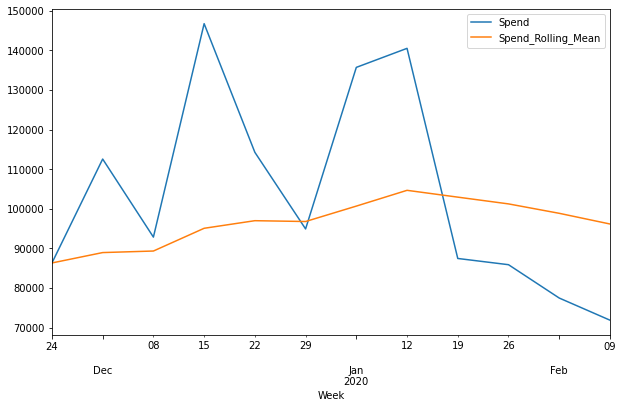

In [25]:
# get the spend mean and rolling mean
df_test_redeemer['Spend_Rolling_Mean'] = df_test_redeemer['Spend'].ewm(alpha = 0.1, adjust = False).mean()
df_test_redeemer[['Spend','Spend_Rolling_Mean']].plot(figsize=(10,6))

In [26]:
# lets calculate spend in redeemer
incremental_spend_redeemer = df_test_redeemer['Spend'].sum()- df_test_redeemer['Spend_Rolling_Mean'].sum()

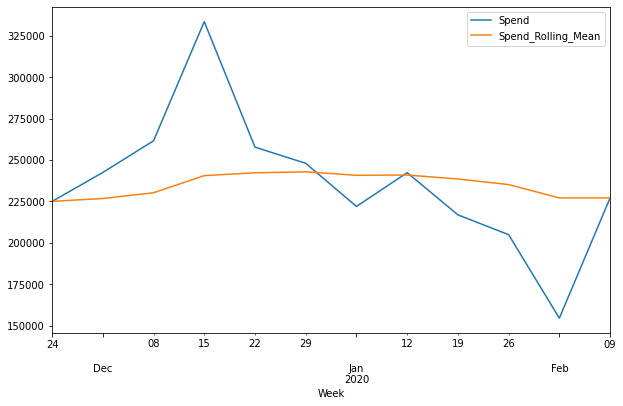

In [27]:
# get the spend mean and rolling mean
df_test_non_redeemer['Spend_Rolling_Mean']=  df_test_non_redeemer['Spend'].ewm(alpha = 0.1, adjust = False).mean()
df_test_non_redeemer[['Spend','Spend_Rolling_Mean']].plot(figsize=(10,6))

In [28]:
# lets calculate spend in redeemer
incremental_spend_non_redeemer = df_test_non_redeemer['Spend'].sum()- df_test_non_redeemer['Spend_Rolling_Mean'].sum()

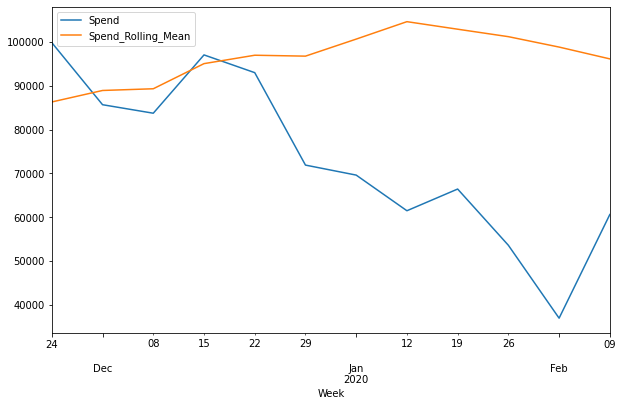

In [29]:
# get the spend mean and rolling mean
df_control['Spend_Rolling_Mean'] = df_test_redeemer['Spend'].ewm(alpha = 0.1, adjust = False).mean()
df_control[['Spend','Spend_Rolling_Mean']].plot(figsize=(10,6))

In [30]:
# lets calculate incremental spend in control
incremental_spend_control = np.abs(df_control['Spend'].sum()- df_control['Spend_Rolling_Mean'].sum())

In [31]:
# lets see the % of incremental purchase made
incremental_spend_redeemer / (incremental_spend_redeemer + incremental_spend_non_redeemer) * 100

82.44148485930214

> The incremental spend in redeemer is 82% of the total incremental purchase in test group.

In [32]:
incremental_spend_control/(incremental_spend_redeemer + incremental_spend_non_redeemer + incremental_spend_control)

0.7213452877191916

> The incremental spend in control group is `1%` of the total incremental purchase in both the groups.

## Return of Investement

Lets calculate the return of investment value in test redeemer group during the sale period.

In [33]:
# lets calculate the values
distinct_redeemers = len(df_test[(df_test['Redeemers'] == "Yes") & (df_test['Week'] >= '2020-01-05') & (df_test['Week'] <= '2020-01-18')]['User ID'].unique())
ROI = (incremental_spend_redeemer * 0.1/ (distinct_redeemers * 10)) * 100
print(ROI)


112.07602680001698
